In [1]:
import os
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
MMEFORECAST = "./MME-HRES/FORECAST/6-MON/"

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
month_order = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}

# Function to extract the date components from MME filename
def extract_date(filename):
    parts = filename.split('-')
#     print(parts)
    month = parts[-3]
#     print(int(parts[-2]), month_order[month])
    return int(parts[-2]), month_order[month]

In [3]:
def palau_eez(df):
    df_eez = gpd.read_file('./palauEEZ.geojson')
    eez = df_eez['geometry'].values[0]
    in_palau = []
    longlat = df[['lon','lat']].values.tolist()
    for x in longlat:
        point = Point(x[0],x[1])
        if eez.contains(point) or point.within(eez):
            in_palau.append((x[0],x[1]))
    return df[df[['lon', 'lat']].apply(tuple, axis=1).isin(in_palau)]

In [4]:
def filter_box(df):
    if "lat" in df:
        filtered = df[(df["lat"]> 1.6214-0.25)&
                                    (df["lat"]< 11.5587+0.1)&(df["lon"]<136.9541+0.1)&
                                    (df["lon"]>129.5088-0.1)]
    else:
        filtered = df[(df["latitude"]> 1.6214-0.25)&
                                    (df["latitude"]< 11.5587+0.1)&(df["longitude"]<136.9541+0.1)&
                                    (df["longitude"]>129.5088-0.1)]
    return filtered

In [5]:
def assign_sst(row):
    below = ["#1400d3","#2864ff","#54affe","#75d2fe","#bdfffe","#ffffff"]
    normal = ["#ffffff","#d2d2d2","#a0a0a0","#828282","#646464","#464646"]
    above = ["#ffffff", "#ffeeb6","#ffd18d","#ff8e74","#ff2b00","#d6142e"]
    if row['level'] == 1.0:
        if row['sst'] > 80:
            return below[0]
        elif row['sst'] > 70:
            return below[1]
        elif row['sst'] > 60:
            return below[2]
        elif row['sst'] > 50:
            return below[3]
        elif row['sst'] > 40:
            return below[4] 
        else:
            return below[5]
    elif row['level'] == 2.0:
        
        if row['sst'] > 80:
            return normal[5]
        elif row['sst'] > 70:
            return normal[4]
        elif row['sst'] > 60:
            return normal[3]
        elif row['sst'] > 50:
            return normal[2]
        elif row['sst'] > 40:
            return normal[1] 
        else:
            return normal[0]
        
    
    elif row['level'] == 3.0:
        if row['sst'] > 80:
            return above[5]
        elif row['sst'] > 70:
            return above[4]
        elif row['sst'] > 60:
            return above[3]
        elif row['sst'] > 50:
            return above[2]
        elif row['sst'] > 40:
            return above[1] 
        else:
            return above[0]

In [6]:
def assign_prec(row):
    below = ["#2f1201","#662b01","#9a6030","#ce9b7c","#e0c0ab","#ffffff"]
    normal = ["#ffffff","#d2d2d2","#a0a0a0","#828282","#646464","#464646"]
    above = ["#ffffff", "#b3fafe","#66f0fe","#2fe4ff","#00aacd","#007b9a"]
    if row['level'] == 1.0:
        if row['prec'] > 80:
            return below[0]
        elif row['prec'] > 70:
            return below[1]
        elif row['prec'] > 60:
            return below[2]
        elif row['prec'] > 50:
            return below[3]
        elif row['prec'] > 40:
            return below[4] 
        else:
            return below[5]
    elif row['level'] == 2.0:
        
        if row['prec'] > 80:
            return normal[5]
        elif row['prec'] > 70:
            return normal[4]
        elif row['prec'] > 60:
            return normal[3]
        elif row['prec'] > 50:
            return normal[2]
        elif row['prec'] > 40:
            return normal[1] 
        else:
            return normal[0]
        
    
    elif row['level'] == 3.0:
        if row['prec'] > 80:
            return above[5]
        elif row['prec'] > 70:
            return above[4]
        elif row['prec'] > 60:
            return above[3]
        elif row['prec'] > 50:
            return above[2]
        elif row['prec'] > 40:
            return above[1] 
        else:
            return above[0]
    else:
        return None

In [7]:
current_prec = [x for x in os.listdir(MMEFORECAST) if 'prec' in x and 'GAUS' in x]
current_sst = [x for x in os.listdir(MMEFORECAST) if 'sst' in x and 'GAUS' in x]

In [8]:
# Sort filenames based on date components
sorted_sst = sorted(current_sst, key=extract_date)

# Get the newest file
newest_sst = sorted_sst[-1]

# Sort filenames based on date components
sorted_prec = sorted(current_prec, key=extract_date)

# Get the newest file
newest_prec = sorted_prec[-1]

In [9]:
newest_xr_prec = xr.open_dataset(MMEFORECAST + newest_prec)
newest_xr_sst = xr.open_dataset(MMEFORECAST + newest_sst)

In [10]:
sst_df = newest_xr_sst.to_dataframe()
sst_df.reset_index(inplace = True)
sst_df = filter_box(sst_df)
sst_df = sst_df.rename(columns={'lat': 'latitude', 'lon': 'longitude'})

prec_df = newest_xr_prec.to_dataframe()
prec_df.reset_index(inplace = True)
prec_df = filter_box(prec_df)
prec_df = prec_df.rename(columns={'lat': 'latitude', 'lon': 'longitude'})

In [11]:
sst_df

,time,level,latitude,longitude,sst
32889,2024-03-01,1.0,1.5,129.5,78.327492
32890,2024-03-01,1.0,1.5,130.5,82.758385
32891,2024-03-01,1.0,1.5,131.5,86.438408
32892,2024-03-01,1.0,1.5,132.5,86.200485
32893,2024-03-01,1.0,1.5,133.5,85.401131
...,...,...,...,...,...
1526892,2024-08-01,4.0,11.5,132.5,190.887711
1526893,2024-08-01,4.0,11.5,133.5,190.962128
1526894,2024-08-01,4.0,11.5,134.5,190.991486
1526895,2024-08-01,4.0,11.5,135.5,190.996185


In [12]:
prec_df

,time,level,latitude,longitude,prec
32889,2024-03-01,1.0,1.5,129.5,44.504322
32890,2024-03-01,1.0,1.5,130.5,44.511749
32891,2024-03-01,1.0,1.5,131.5,45.827446
32892,2024-03-01,1.0,1.5,132.5,45.870190
32893,2024-03-01,1.0,1.5,133.5,48.437233
...,...,...,...,...,...
1526892,2024-08-01,4.0,11.5,132.5,-51.815342
1526893,2024-08-01,4.0,11.5,133.5,-52.566231
1526894,2024-08-01,4.0,11.5,134.5,-52.454903
1526895,2024-08-01,4.0,11.5,135.5,-52.330219


In [13]:
from pandas import Timestamp

In [14]:
from sklearn.neighbors import NearestNeighbors
from geopandas import GeoDataFrame
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.ops import cascaded_union
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import json

In [15]:
from shapely import geometry
p1 = geometry.Point(129.5088 -0.1,1.6214-0.25)
p2 = geometry.Point(136.9541 + 0.1, 1.6214-0.25)
p3 = geometry.Point(136.9541+0.1,11.5587+0.1)
p4 = geometry.Point(129.5088-0.1,11.5587+0.1)

pointList = [p1, p2, p3, p4, p1]
poly = geometry.Polygon([[p.x, p.y] for p in pointList])

sdf = pd.DataFrame(
    {
        "Country": ["Palau"],
        "geometry": [poly
        ],
    }
)
gdf = gpd.GeoDataFrame(sdf, geometry="geometry")
# gdf.to_file('palau_rectangle_with_margins.json', driver='GeoJSON')

In [16]:
# boundary = gpd.read_file('palauEEZ.geojson')
boundary = gdf
boundary = boundary.explode()
boundary = boundary.set_crs(crs="EPSG:3395", allow_override=True)
boundary_shape = cascaded_union(boundary.geometry)

df_eez = gpd.read_file('palauEEZ.geojson')
eez = df_eez['geometry'].values[0]

def getSSTJSON(df, time = Timestamp('2024-03-01 00:00:00')):
    df_slice = df[df['time'] == time]
    
    max_index = df_slice[df_slice['level']!=4.0].groupby(['latitude', 'longitude', 'time'])['sst'].idxmax()
    df_slice = df.loc[max_index]


    coordinates = df_slice[['latitude','longitude','sst']]
    coordinates = coordinates.drop_duplicates()

    df_slice = df_slice.sort_values(by=['longitude','latitude'], ascending=[False,True])
    df_slice['new_col'] = list(zip(df_slice.latitude, df_slice.longitude))#         coordinates = coordinates.drop_duplicates()
    coordinates = []

    for c in df_slice['new_col']:
        coordinates.append([c[0],c[1]])
    points = []
    for x in coordinates:
        points.append(Point(x[1],x[0]))
        
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
    gdf_proj = points_gdf.to_crs(boundary.crs)

    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
    voronoi_poly = GeoDataFrame(crs="EPSG:3395", geometry=list(poly_shapes.values()))
    
    longitude = []
    latitude = []
    for pt in pts:
        longitude.append(coords[pt][0])
        latitude.append(coords[pt][1])
    voronoi_poly["longitude"] = longitude
    voronoi_poly["latitude"] = latitude

    
    df_slice = df_slice.drop(['new_col'], axis=1)
    

    df_slice['geometry'] = voronoi_poly.sort_values(by=['longitude','latitude'], ascending=[False,True])['geometry'].tolist()
    df_slice = df_slice.reset_index()
    df_slice = df_slice.drop('index',axis=1)
    
    json_gdf = GeoDataFrame(df_slice,crs="EPSG:3395")
    
    palau_land = gpd.read_file('palau.geojson')
    palau_land = palau_land.drop(['type','id','tags','meta'],axis = 1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
    
    palau_eez = gpd.read_file('palauEEZ.geojson')
    trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")

    trimmed['fill'] = trimmed.apply(assign_sst, axis=1)
    
    
    
    
    
    
    
    
    
    
    #Plotting voronoi
    fig, ax = plt.subplots(figsize=(12, 10))
    boundary.plot(ax=ax, color="gray")
    trimmed.plot(ax=ax, color=trimmed["fill"])
    points_gdf.plot(ax=ax, markersize=1, color="black")
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    
    return trimmed.drop(columns=['time'])


def getPrecJSON(df, time = Timestamp('2024-03-01 00:00:00')):
    df_slice = df[df['time'] == time]
    
    max_index = df_slice[df_slice['level']!=4.0].groupby(['latitude', 'longitude', 'time'])['prec'].idxmax()
    df_slice = df.loc[max_index]


    coordinates = df_slice[['latitude','longitude','prec']]
    coordinates = coordinates.drop_duplicates()

    df_slice = df_slice.sort_values(by=['longitude','latitude'], ascending=[False,True])
    df_slice['new_col'] = list(zip(df_slice.latitude, df_slice.longitude))#         coordinates = coordinates.drop_duplicates()
    coordinates = []

    for c in df_slice['new_col']:
        coordinates.append([c[0],c[1]])
    points = []
    for x in coordinates:
        points.append(Point(x[1],x[0]))
        
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
    gdf_proj = points_gdf.to_crs(boundary.crs)

    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
    voronoi_poly = GeoDataFrame(crs="EPSG:3395", geometry=list(poly_shapes.values()))
    
    longitude = []
    latitude = []
    for pt in pts:
        longitude.append(coords[pt][0])
        latitude.append(coords[pt][1])
    voronoi_poly["longitude"] = longitude
    voronoi_poly["latitude"] = latitude

    
    df_slice = df_slice.drop(['new_col'], axis=1)
    

    df_slice['geometry'] = voronoi_poly.sort_values(by=['longitude','latitude'], ascending=[False,True])['geometry'].tolist()
    df_slice = df_slice.reset_index()
    df_slice = df_slice.drop('index',axis=1)
    
    json_gdf = GeoDataFrame(df_slice,crs="EPSG:3395")
    
    palau_land = gpd.read_file('palau.geojson')
    palau_land = palau_land.drop(['type','id','tags','meta'],axis = 1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
    
    palau_eez = gpd.read_file('palauEEZ.geojson')
    trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")

    trimmed['fill'] = trimmed.apply(assign_prec, axis=1)
    
    
    
    
    
    
    
    
    
    
    #Plotting voronoi
    fig, ax = plt.subplots(figsize=(12, 10))
    boundary.plot(ax=ax, color="gray")
    trimmed.plot(ax=ax, color=trimmed["fill"])
    points_gdf.plot(ax=ax, markersize=1, color="black")
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    
    return trimmed.drop(columns=['time'])

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boundary = boundary.explode()
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:5: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary_shape = cascaded_union(boundary.geometry)


In [17]:
len("2024-03-01")

10

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:58: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:61: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


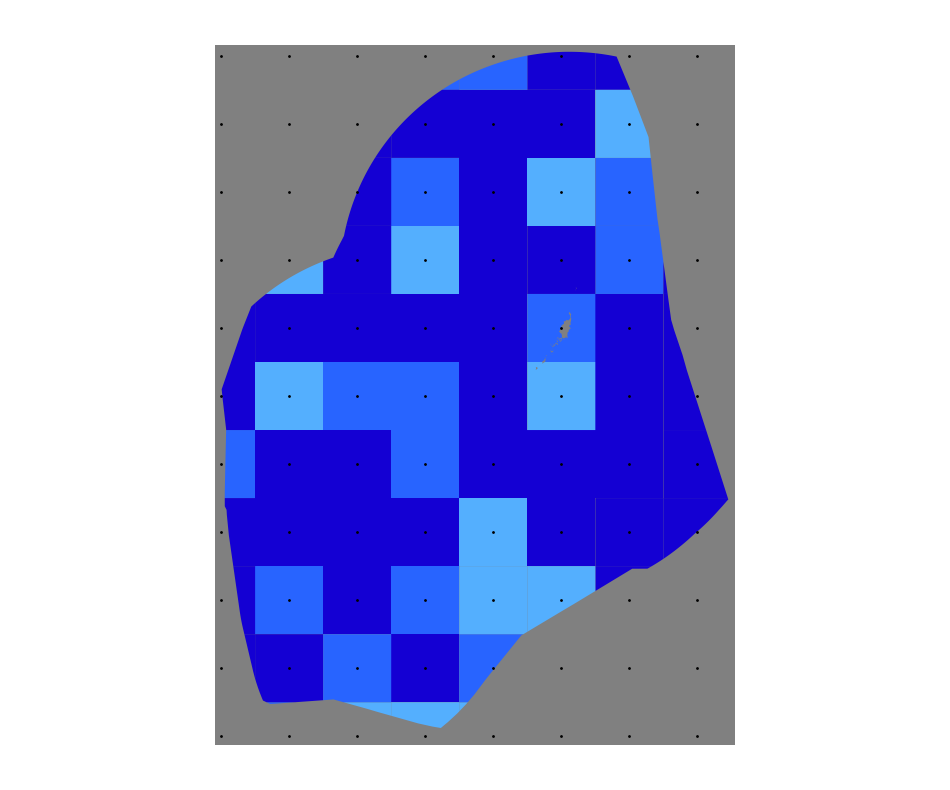

./MME-HRES/FORECAST/6-MON/SST/SST_GAUS_2024-03-01.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:58: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:61: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


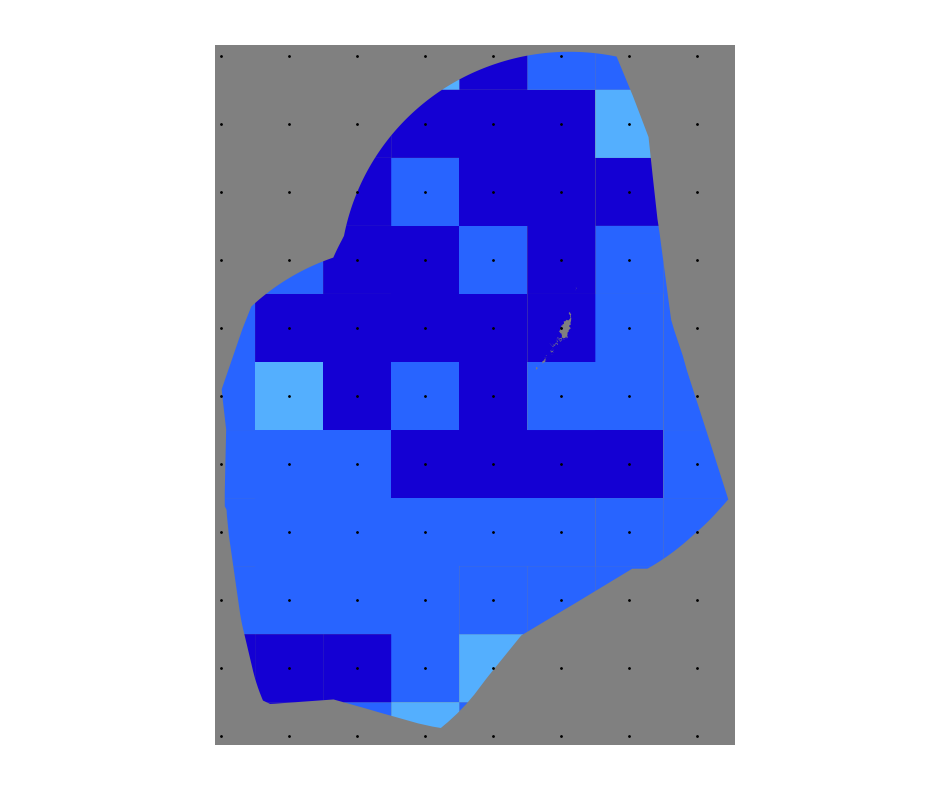

./MME-HRES/FORECAST/6-MON/SST/SST_GAUS_2024-04-01.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:58: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:61: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


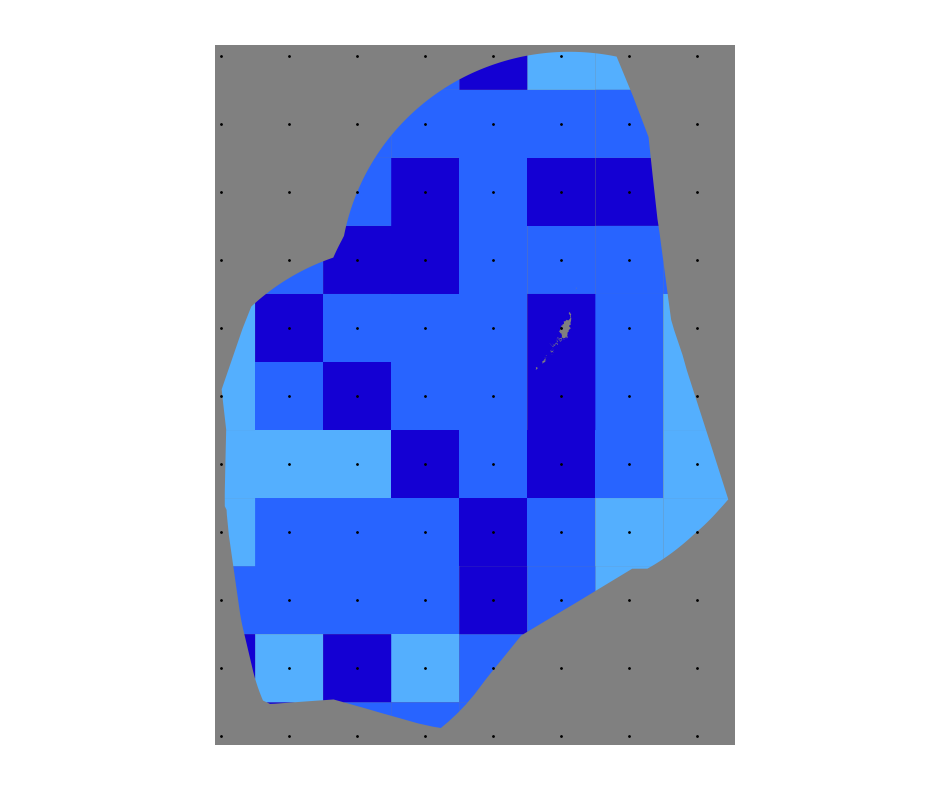

./MME-HRES/FORECAST/6-MON/SST/SST_GAUS_2024-05-01.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:58: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:61: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


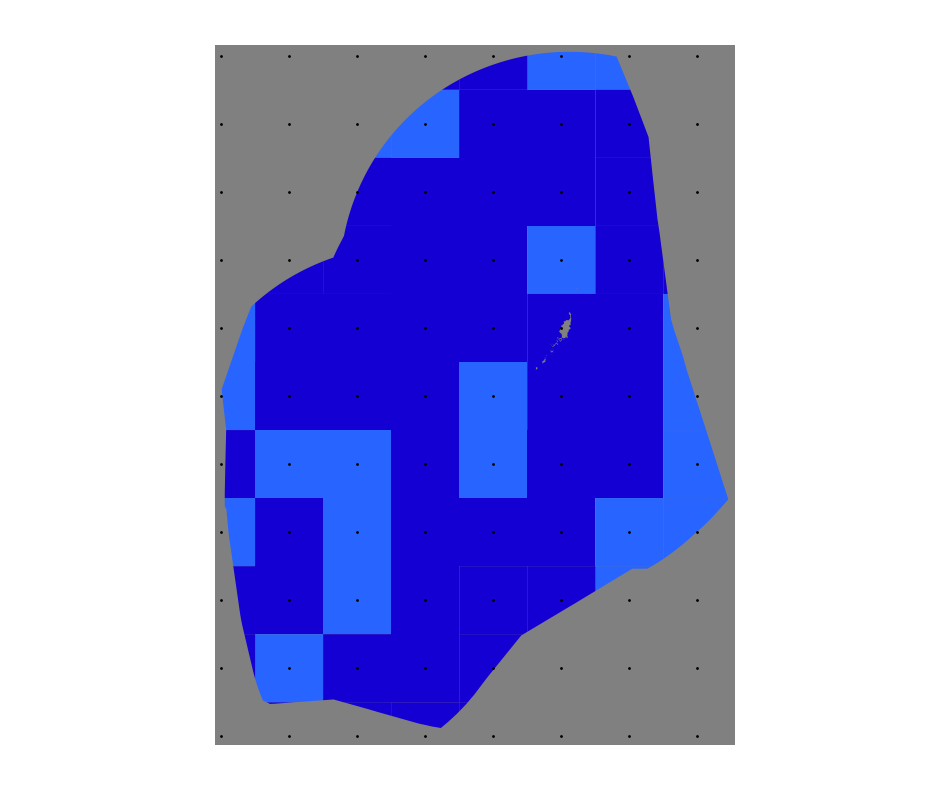

./MME-HRES/FORECAST/6-MON/SST/SST_GAUS_2024-06-01.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:58: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:61: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


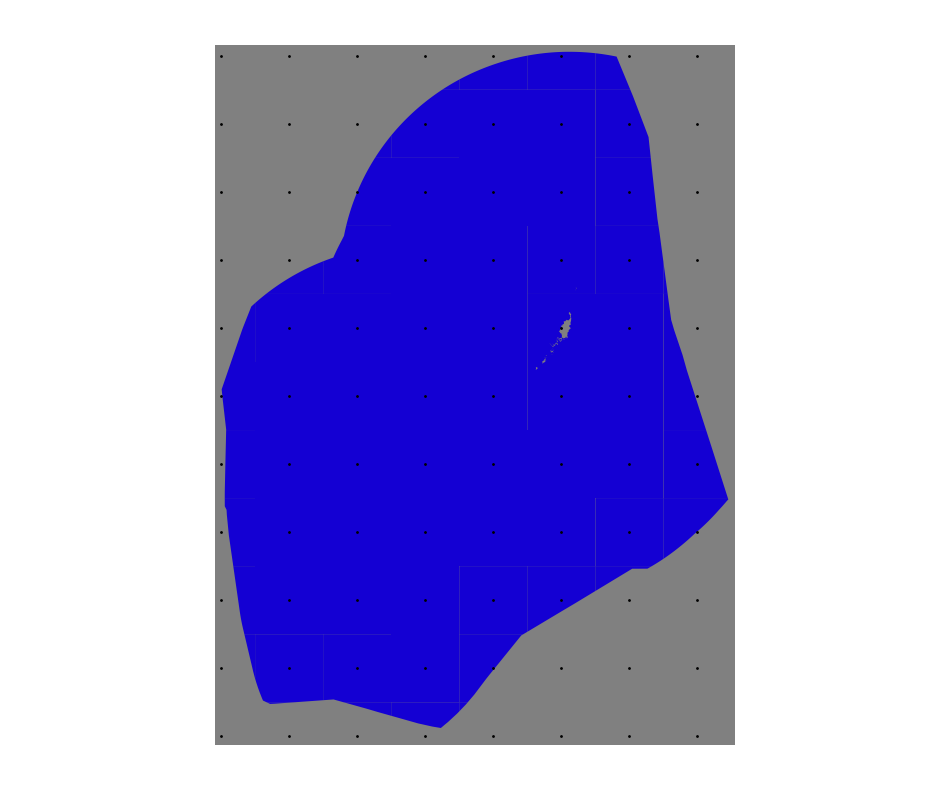

./MME-HRES/FORECAST/6-MON/SST/SST_GAUS_2024-07-01.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:58: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:61: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


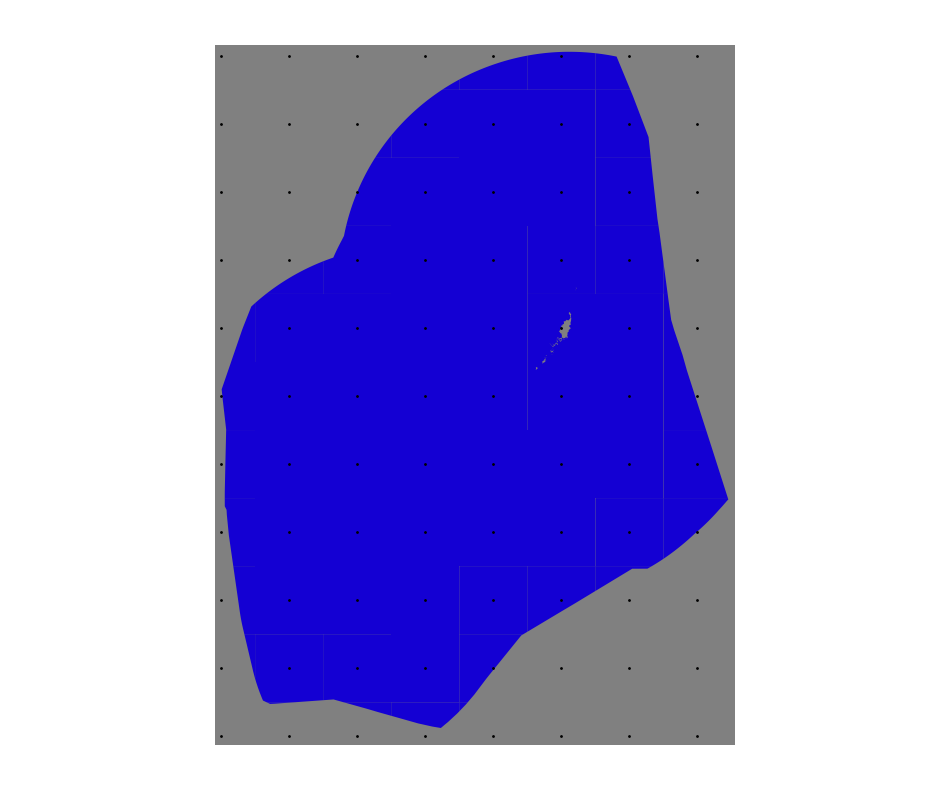

./MME-HRES/FORECAST/6-MON/SST/SST_GAUS_2024-08-01.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:134: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:137: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


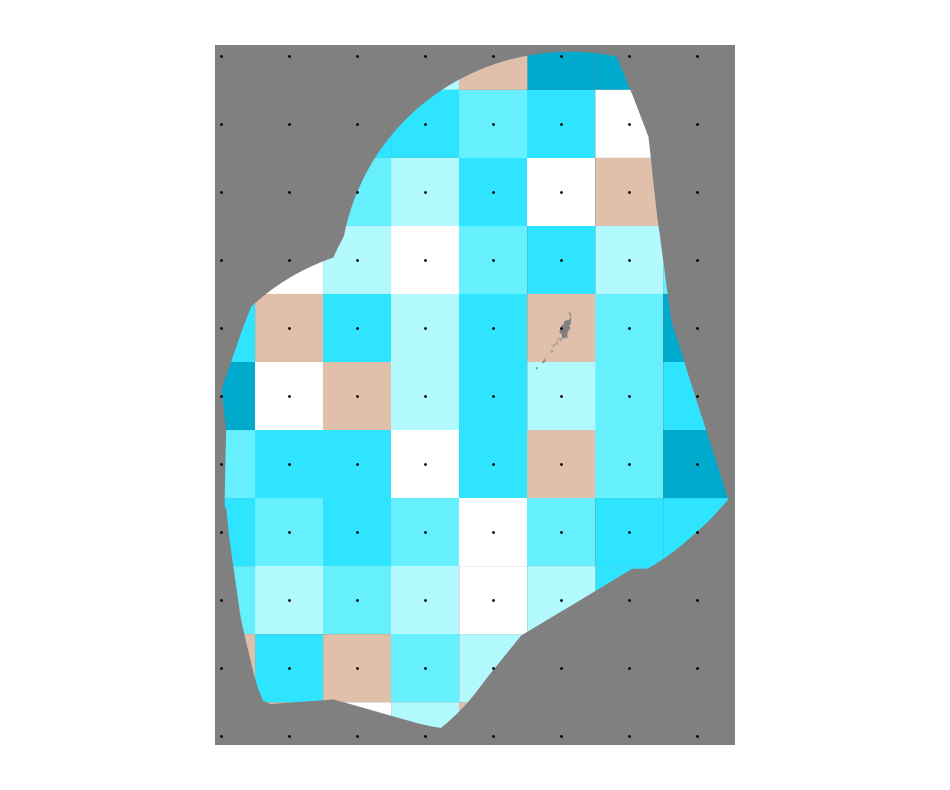

./MME-HRES/FORECAST/6-MON/PREC/PREC_GAUS_2024-03-01.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:134: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:137: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


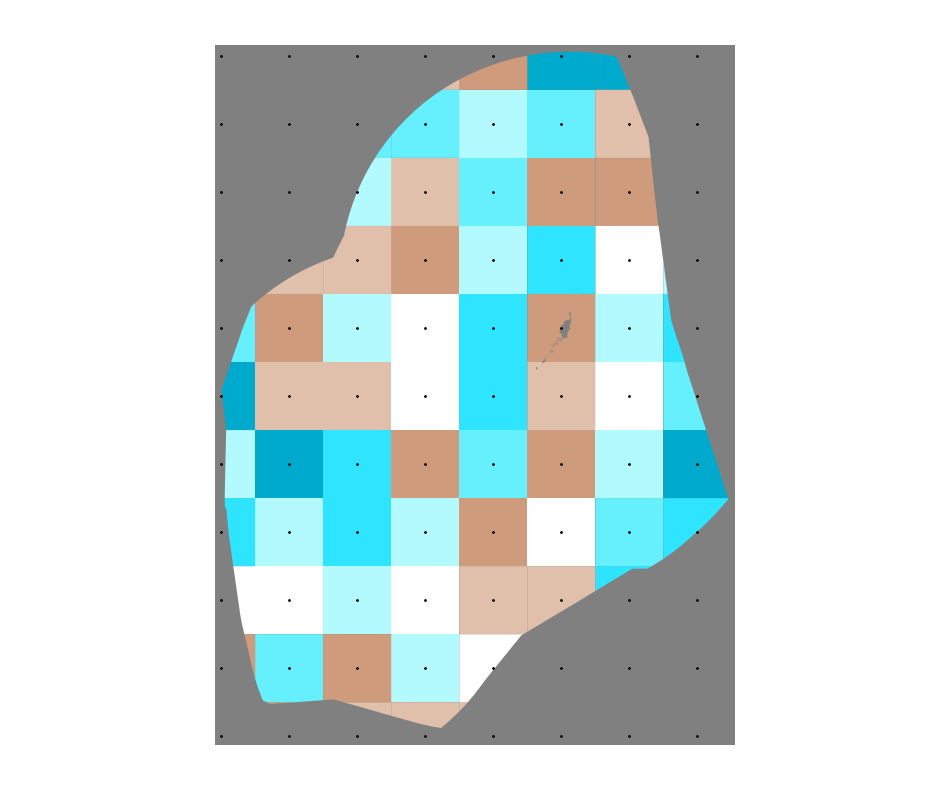

./MME-HRES/FORECAST/6-MON/PREC/PREC_GAUS_2024-04-01.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:134: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:137: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


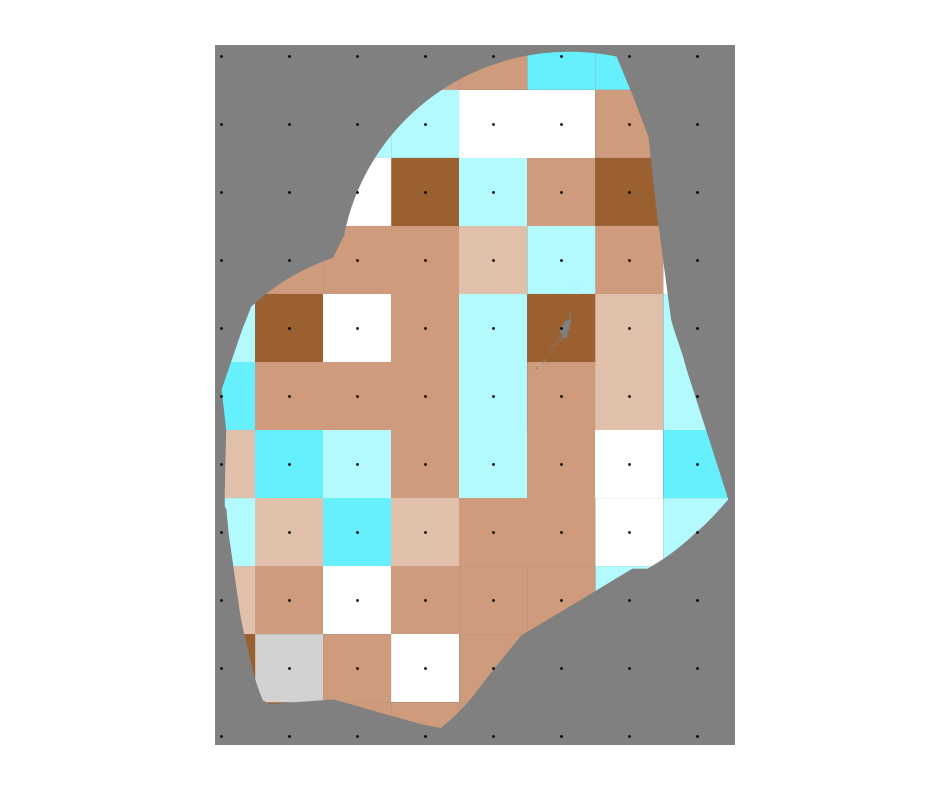

./MME-HRES/FORECAST/6-MON/PREC/PREC_GAUS_2024-05-01.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:134: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:137: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


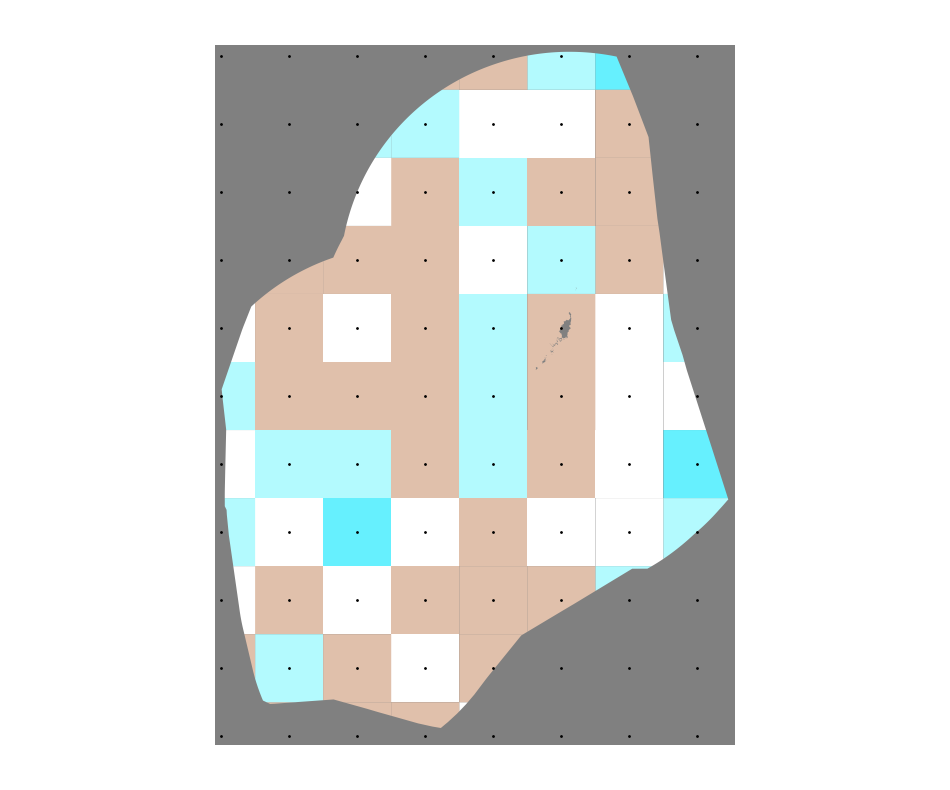

./MME-HRES/FORECAST/6-MON/PREC/PREC_GAUS_2024-06-01.json


KeyboardInterrupt: 

In [18]:
if not os.path.exists("./MME-HRES/FORECAST/6-MON/SST"):
    os.makedirs("./MME-HRES/FORECAST/6-MON/SST")
if not os.path.exists("./MME-HRES/FORECAST/6-MON/PREC"):
    os.makedirs("./MME-HRES/FORECAST/6-MON/PREC")
    
    
for x in sst_df['time'].unique():
    currgeo = getSSTJSON(df = sst_df, time = x).to_json()
    json_object = json.dumps(currgeo, indent=4)
    geojson_folder = './MME-HRES/FORECAST/6-MON/SST/'
    geojson_dir = geojson_folder + "SST_GAUS_" + str(x)[:10] +".json"
    with open(geojson_dir, "w") as outfile:
        outfile.write(json_object)
        print(geojson_dir)

for x in prec_df['time'].unique():
    currgeo = getPrecJSON(df = prec_df, time = x).to_json()
    json_object = json.dumps(currgeo, indent=4)
    geojson_folder = './MME-HRES/FORECAST/6-MON/PREC/'
    geojson_dir = geojson_folder + "PREC_GAUS_" + str(x)[:10] +".json"
    with open(geojson_dir, "w") as outfile:
        outfile.write(json_object)
        print(geojson_dir)
    

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:58: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/3925461924.py:61: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


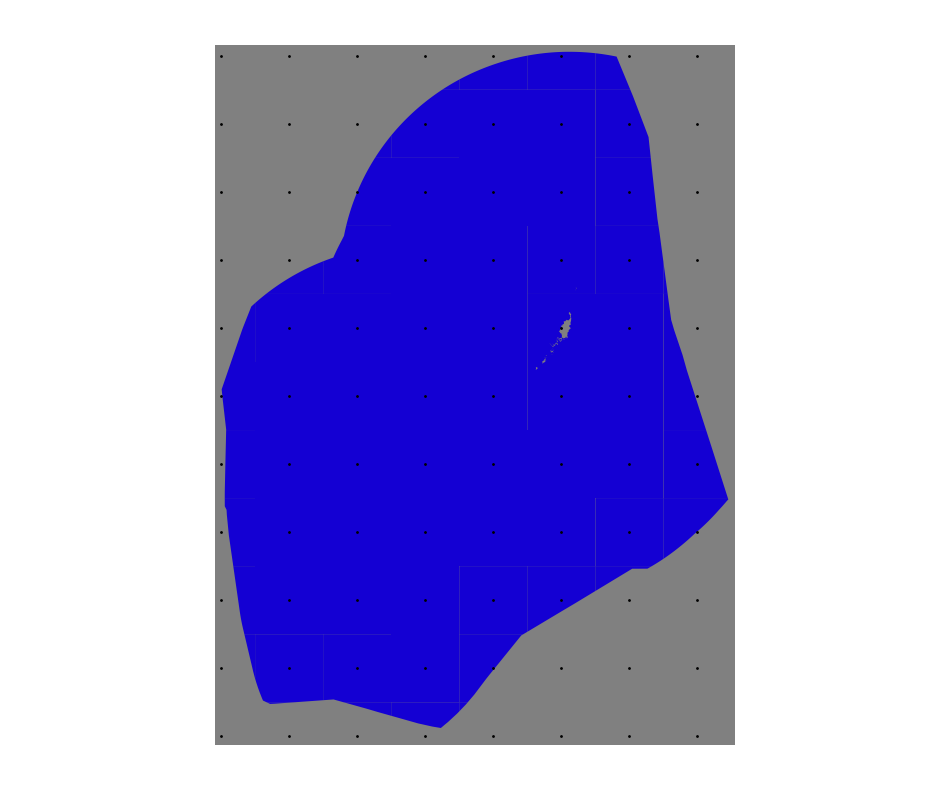

In [19]:
test = getSSTJSON(df = sst_df, time = x)

In [20]:
eez = gpd.read_file('./palauEEZ.geojson')

In [21]:
# boundary = gpd.read_file('palauEEZ.geojson')
boundary = gdf
boundary = boundary.explode()
boundary = boundary.set_crs(crs="EPSG:3395", allow_override=True)
boundary_shape = cascaded_union(boundary.geometry)

df_eez = gpd.read_file('palauEEZ.geojson')
eez = df_eez['geometry'].values[0]

def getSSTJSON(df, time = Timestamp('2024-03-01 00:00:00')):
    df_slice = df[df['time'] == time]
    
    max_index = df_slice[df_slice['level']!=4.0].groupby(['latitude', 'longitude', 'time'])['sst'].idxmax()
    df_slice = df.loc[max_index]


    coordinates = df_slice[['latitude','longitude','sst']]
    coordinates = coordinates.drop_duplicates()

    df_slice = df_slice.sort_values(by=['longitude','latitude'], ascending=[False,True])
    df_slice['new_col'] = list(zip(df_slice.latitude, df_slice.longitude))#         coordinates = coordinates.drop_duplicates()
    coordinates = []

    for c in df_slice['new_col']:
        coordinates.append([c[0],c[1]])
    points = []
    for x in coordinates:
        points.append(Point(x[1],x[0]))
        
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
    gdf_proj = points_gdf.to_crs(boundary.crs)

    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
#     vdf = pd.DataFrame(pts)
    vdf = pd.DataFrame.from_dict(pts, orient='index', columns = ['pts'])
#     print(vdf)
    voronoi_poly = GeoDataFrame(vdf, crs="EPSG:3395", geometry=list(poly_shapes.values()))
#     print(coords)
#     longitude = []
#     latitude = []
#     for pt in pts:
#         longitude.append(coords[pt][0])
#         latitude.append(coords[pt][1])


#     voronoi_poly["longitude"] = longitude
#     voronoi_poly["latitude"] = latitude
    
    voronoi_poly["longitude"] = voronoi_poly.apply(lambda row: coords[row['pts']][0], axis=1)
    voronoi_poly["latitude"] = voronoi_poly.apply(lambda row: coords[row['pts']][1], axis=1)
#     return voronoi_poly, pts
    df_slice = df_slice.drop(['new_col'], axis=1)
    #not needed line
    df_slice = df_slice. sort_values(by=['longitude','latitude'], ascending=[False,True])
#     return voronoi_poly, df_slice
    
    df_slice['geometry'] = voronoi_poly.sort_values(by=['longitude','latitude'], ascending=[False,True])['geometry'].tolist()
    df_slice = df_slice.reset_index()
    df_slice = df_slice.drop('index',axis=1)
    
    json_gdf = GeoDataFrame(df_slice,crs="EPSG:3395")
    
    palau_land = gpd.read_file('palau.geojson')
    palau_land = palau_land.drop(['type','id','tags','meta'],axis = 1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
    
    palau_eez = gpd.read_file('palauEEZ.geojson')
    trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")

    trimmed['fill'] = trimmed.apply(assign_sst, axis=1)
    
    
    
    
    
    
    
    
    
    
    #Plotting voronoi
    fig, ax = plt.subplots(figsize=(12, 10))
    boundary.plot(ax=ax, color="gray")
    trimmed.plot(ax=ax, color=trimmed["fill"])
    points_gdf.plot(ax=ax, markersize=1, color="black")
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    
    return trimmed.drop(columns=['time'])

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/503562402.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boundary = boundary.explode()
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/503562402.py:5: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary_shape = cascaded_union(boundary.geometry)


In [24]:
# boundary = gpd.read_file('palauEEZ.geojson')
boundary = gdf
boundary = boundary.explode()
boundary = boundary.set_crs(crs="EPSG:3395", allow_override=True)
boundary_shape = cascaded_union(boundary.geometry)

df_eez = gpd.read_file('palauEEZ.geojson')
eez = df_eez['geometry'].values[0]

def getAllSSTJSON(df, time = Timestamp('2024-03-01 00:00:00')):
    df_slice = df[df['time'] == time]
    max_index = df_slice[df_slice['level']!=4.0].groupby(['latitude', 'longitude', 'time'])['sst'].idxmax()
    df_slice = df.loc[max_index]


    coordinates = df_slice[['latitude','longitude','sst']]
    coordinates = coordinates.drop_duplicates()

    df_slice = df_slice.sort_values(by=['longitude','latitude'], ascending=[False,True])
    df_slice['new_col'] = list(zip(df_slice.latitude, df_slice.longitude))#         coordinates = coordinates.drop_duplicates()
    coordinates = []

    for c in df_slice['new_col']:
        coordinates.append([c[0],c[1]])
    points = []
    for x in coordinates:
        points.append(Point(x[1],x[0]))
        
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
    gdf_proj = points_gdf.to_crs(boundary.crs)

    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
    

    vdf = pd.DataFrame.from_dict(pts, orient='index', columns = ['pts'])
    voronoi_poly = GeoDataFrame(vdf, crs="EPSG:3395", geometry=list(poly_shapes.values()))

    
    voronoi_poly["longitude"] = voronoi_poly.apply(lambda row: coords[row['pts']][0], axis=1)
    voronoi_poly["latitude"] = voronoi_poly.apply(lambda row: coords[row['pts']][1], axis=1)
    df_slice = df_slice.drop(['new_col'], axis=1)
    #not needed line
    df_slice = df_slice. sort_values(by=['longitude','latitude'], ascending=[False,True])    
    df_slice['geometry'] = voronoi_poly.sort_values(by=['longitude','latitude'], ascending=[False,True])['geometry'].tolist()
    df_slice = df_slice.reset_index()
    df_slice = df_slice.drop('index',axis=1)
    
    json_gdf = GeoDataFrame(df_slice,crs="EPSG:3395")
    palau_land = gpd.read_file('palau.geojson')
    palau_land = palau_land.drop(['type','id','tags','meta'],axis = 1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
    
    palau_eez = gpd.read_file('palauEEZ.geojson')
    trimmed = gpd.overlay(json_gdf,palau_eez, how = "intersection")

#     trimmed['fill'] = trimmed.apply(assign_sst, axis=1)
    
#     trimmed['coords'] = trimmed['latitude'] + trimmed['longitude']
    trimmed['point'] = trimmed.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    
    laea_polygons = trimmed['geometry'].to_crs(f'+proj=laea +lat_0={eez.centroid.coords[0][1]} +lon_0={eez.centroid.coords[0][0]} +x_0=0 +y_0=0 +a=6371000 +b=6371000 +units=m +no_defs')
    trimmed['area'] = laea_polygons.area
    trimmed['parea'] = trimmed['area']/trimmed['area'].sum()
    
    
    df['point'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    
    df = df[df['point'].isin(trimmed['point'].unique())]
    
    
    df_filtered = pd.merge(df, trimmed[['geometry', 'point','area','parea']], on='point', how='left')
    
    df_filtered['fill'] = df_filtered.apply(assign_sst, axis=1)
    

    
    
    
    
    
    
    
    return df_filtered

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/1727699727.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boundary = boundary.explode()
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/1727699727.py:5: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary_shape = cascaded_union(boundary.geometry)


In [25]:
xtest = getAllSSTJSON(df = sst_df)

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/1727699727.py:53: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_37129/1727699727.py:56: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_eez, how = "intersection")


In [26]:
xtest

,time,level,latitude,longitude,sst,point,geometry,area,parea,fill
0,2024-03-01,1.0,1.5,130.5,82.758385,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#1400d3
1,2024-03-01,1.0,1.5,131.5,86.438408,POINT (131.5 1.5),"POLYGON ((131.299 2.000, 132.000 2.000, 132.00...",0.069911,0.001382,#1400d3
2,2024-03-01,1.0,1.5,132.5,86.200485,POINT (132.5 1.5),"POLYGON ((132.000 1.801, 132.000 2.000, 133.00...",0.288648,0.005708,#1400d3
3,2024-03-01,1.0,1.5,133.5,85.401131,POINT (133.5 1.5),"POLYGON ((133.000 1.866, 133.000 2.000, 133.12...",0.008653,0.000171,#1400d3
4,2024-03-01,1.0,2.5,129.5,69.689308,POINT (129.5 2.5),"POLYGON ((129.842 3.000, 130.000 3.000, 130.00...",0.052841,0.001045,#54affe
...,...,...,...,...,...,...,...,...,...,...
1651,2024-08-01,4.0,10.5,135.5,191.145584,POINT (135.5 10.5),"POLYGON ((135.814 10.000, 135.000 10.000, 135....",0.698069,0.013804,None
1652,2024-08-01,4.0,11.5,132.5,190.887711,POINT (132.5 11.5),"POLYGON ((133.000 11.151, 133.000 11.000, 132....",0.019863,0.000393,None
1653,2024-08-01,4.0,11.5,133.5,190.962128,POINT (133.5 11.5),"POLYGON ((133.000 11.000, 133.000 11.151, 133....",0.357457,0.007068,None
1654,2024-08-01,4.0,11.5,134.5,190.991486,POINT (134.5 11.5),"POLYGON ((134.000 11.000, 134.000 11.502, 134....",0.547061,0.010818,None


In [27]:
xtest['psst'] = xtest['parea']*xtest['sst']

In [28]:
xtest

,time,level,latitude,longitude,sst,point,geometry,area,parea,fill,psst
0,2024-03-01,1.0,1.5,130.5,82.758385,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#1400d3,0.009010
1,2024-03-01,1.0,1.5,131.5,86.438408,POINT (131.5 1.5),"POLYGON ((131.299 2.000, 132.000 2.000, 132.00...",0.069911,0.001382,#1400d3,0.119494
2,2024-03-01,1.0,1.5,132.5,86.200485,POINT (132.5 1.5),"POLYGON ((132.000 1.801, 132.000 2.000, 133.00...",0.288648,0.005708,#1400d3,0.492007
3,2024-03-01,1.0,1.5,133.5,85.401131,POINT (133.5 1.5),"POLYGON ((133.000 1.866, 133.000 2.000, 133.12...",0.008653,0.000171,#1400d3,0.014612
4,2024-03-01,1.0,2.5,129.5,69.689308,POINT (129.5 2.5),"POLYGON ((129.842 3.000, 130.000 3.000, 130.00...",0.052841,0.001045,#54affe,0.072816
...,...,...,...,...,...,...,...,...,...,...,...
1651,2024-08-01,4.0,10.5,135.5,191.145584,POINT (135.5 10.5),"POLYGON ((135.814 10.000, 135.000 10.000, 135....",0.698069,0.013804,None,2.638496
1652,2024-08-01,4.0,11.5,132.5,190.887711,POINT (132.5 11.5),"POLYGON ((133.000 11.151, 133.000 11.000, 132....",0.019863,0.000393,None,0.074976
1653,2024-08-01,4.0,11.5,133.5,190.962128,POINT (133.5 11.5),"POLYGON ((133.000 11.000, 133.000 11.151, 133....",0.357457,0.007068,None,1.349785
1654,2024-08-01,4.0,11.5,134.5,190.991486,POINT (134.5 11.5),"POLYGON ((134.000 11.000, 134.000 11.502, 134....",0.547061,0.010818,None,2.066062


In [33]:
APCCPrecProb = xtest[['time','level','latitude','longitude','sst','area','parea','fill','psst']]

In [35]:
APCCPrecProb.to_csv('APCCPrecProb.csv')

In [39]:
xtest

,time,level,latitude,longitude,sst,point,geometry,area,parea,fill,psst
0,2024-03-01,1.0,1.5,130.5,82.758385,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#1400d3,0.009010
1,2024-03-01,1.0,1.5,131.5,86.438408,POINT (131.5 1.5),"POLYGON ((131.299 2.000, 132.000 2.000, 132.00...",0.069911,0.001382,#1400d3,0.119494
2,2024-03-01,1.0,1.5,132.5,86.200485,POINT (132.5 1.5),"POLYGON ((132.000 1.801, 132.000 2.000, 133.00...",0.288648,0.005708,#1400d3,0.492007
3,2024-03-01,1.0,1.5,133.5,85.401131,POINT (133.5 1.5),"POLYGON ((133.000 1.866, 133.000 2.000, 133.12...",0.008653,0.000171,#1400d3,0.014612
4,2024-03-01,1.0,2.5,129.5,69.689308,POINT (129.5 2.5),"POLYGON ((129.842 3.000, 130.000 3.000, 130.00...",0.052841,0.001045,#54affe,0.072816
...,...,...,...,...,...,...,...,...,...,...,...
1651,2024-08-01,4.0,10.5,135.5,191.145584,POINT (135.5 10.5),"POLYGON ((135.814 10.000, 135.000 10.000, 135....",0.698069,0.013804,None,2.638496
1652,2024-08-01,4.0,11.5,132.5,190.887711,POINT (132.5 11.5),"POLYGON ((133.000 11.151, 133.000 11.000, 132....",0.019863,0.000393,None,0.074976
1653,2024-08-01,4.0,11.5,133.5,190.962128,POINT (133.5 11.5),"POLYGON ((133.000 11.000, 133.000 11.151, 133....",0.357457,0.007068,None,1.349785
1654,2024-08-01,4.0,11.5,134.5,190.991486,POINT (134.5 11.5),"POLYGON ((134.000 11.000, 134.000 11.502, 134....",0.547061,0.010818,None,2.066062


In [29]:
testsum = xtest.groupby(['time','level'])['psst'].agg('sum')

In [30]:
xtest[xtest['level']!= 4.0].groupby(['time'])['psst'].agg('sum')

time
2024-03-01    100.000005
2024-04-01    100.000004
2024-05-01    100.000004
2024-06-01    100.000005
2024-07-01    100.000004
2024-08-01    100.000006
Name: psst, dtype: float64

In [31]:
testsum

time        level
2024-03-01  1.0       79.189543
            2.0       17.503614
            3.0        3.306849
            4.0      179.189543
2024-04-01  1.0       76.598820
            2.0       17.188513
            3.0        6.212671
            4.0      176.598818
2024-05-01  1.0       74.556676
            2.0       17.101555
            3.0        8.341773
            4.0      174.556677
2024-06-01  1.0       84.165410
            2.0       11.666934
            3.0        4.167660
            4.0      184.165411
2024-07-01  1.0       92.051967
            2.0        6.527606
            3.0        1.420431
            4.0      192.051967
2024-08-01  1.0       90.029645
            2.0        7.922288
            3.0        2.048072
            4.0      190.029645
Name: psst, dtype: float64

In [30]:
for t in xtest['time'].unique():
#     print(xtest[(xtest['time']== t)&(xtest['level']== 1.0)].groupby([]))
#     print(xtest[xtest['time']== t].groupby(['level','longitude','latitude']))
print(xtest[xtest['time']== t].groupby(['level','longitude','latitude']))
    break

IndentationError: expected an indented block (534048832.py, line 4)

In [31]:
xtest[xtest['point'] == Point(130.5,1.5)]

,time,level,latitude,longitude,sst,point,geometry,area,parea,fill,psst
0,2024-03-01,1.0,1.5,130.5,82.758385,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#1400d3,0.009010
69,2024-03-01,2.0,1.5,130.5,17.053295,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#ffffff,0.001857
138,2024-03-01,3.0,1.5,130.5,0.188327,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#ffffff,0.000021
207,2024-03-01,4.0,1.5,130.5,182.758392,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,None,0.019896
276,2024-04-01,1.0,1.5,130.5,94.117340,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#1400d3,0.010246
345,2024-04-01,2.0,1.5,130.5,5.648033,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#ffffff,0.000615
414,2024-04-01,3.0,1.5,130.5,0.234623,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#ffffff,0.000026
483,2024-04-01,4.0,1.5,130.5,194.117340,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,None,0.021133
552,2024-05-01,1.0,1.5,130.5,92.299187,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#1400d3,0.010048
621,2024-05-01,2.0,1.5,130.5,6.669257,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#ffffff,0.000726


In [638]:
xtest[xtest['point'] == Point(130.5,1.5)]

,time,level,latitude,longitude,sst,point,geometry,area,parea,fill
0,2024-03-01,1.0,1.5,130.5,82.758385,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#1400d3
69,2024-03-01,2.0,1.5,130.5,17.053295,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#ffffff
138,2024-03-01,3.0,1.5,130.5,0.188327,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#ffffff
207,2024-03-01,4.0,1.5,130.5,182.758392,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,None
276,2024-04-01,1.0,1.5,130.5,94.117340,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#1400d3
345,2024-04-01,2.0,1.5,130.5,5.648033,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#ffffff
414,2024-04-01,3.0,1.5,130.5,0.234623,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#ffffff
483,2024-04-01,4.0,1.5,130.5,194.117340,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,None
552,2024-05-01,1.0,1.5,130.5,92.299187,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#1400d3
621,2024-05-01,2.0,1.5,130.5,6.669257,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#ffffff


In [45]:
xtest.to_pickle("./c.pkl")

In [49]:
xtest[xtest['point'] == Point(130.5,1.5)][['time','level','sst']]

,time,level,sst
0,2024-03-01,1.0,82.758385
69,2024-03-01,2.0,17.053295
138,2024-03-01,3.0,0.188327
207,2024-03-01,4.0,182.758392
276,2024-04-01,1.0,94.117340
345,2024-04-01,2.0,5.648033
414,2024-04-01,3.0,0.234623
483,2024-04-01,4.0,194.117340
552,2024-05-01,1.0,92.299187
621,2024-05-01,2.0,6.669257


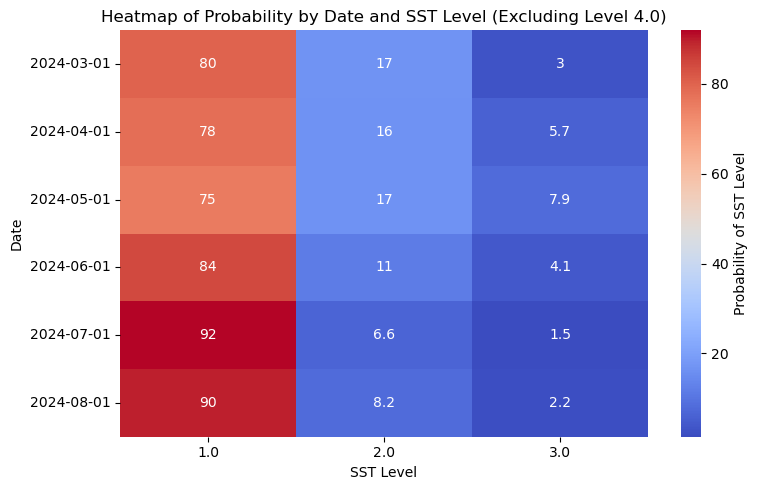

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


xtest['time'] = pd.to_datetime(xtest['time']).dt.date

# Filter out level 4.0
df_filtered = xtest[xtest['level'] != 4.0]

# 3. Heatmap of Probability by Date and Level
def heatmap_probability(df):
    pivot_table = df.pivot_table(index='time', columns='level', values='sst')
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm', cbar_kws={'label': 'Probability of SST Level'})
    plt.title('Heatmap of Probability by Date and SST Level (Excluding Level 4.0)')
    plt.xlabel('SST Level')
    plt.ylabel('Date')
    plt.tight_layout()
    plt.show()

# Call the heatmap function
heatmap_probability(df_filtered)


In [40]:
df_filtered = xtest[xtest['level'] != 4.0]


,time,level,latitude,longitude,sst,point,geometry,area,parea,fill,psst
0,2024-03-01,1.0,1.5,130.5,82.758385,POINT (130.5 1.5),"POLYGON ((130.168 2.000, 130.588 2.000, 130.29...",0.005506,0.000109,#1400d3,0.009010
1,2024-03-01,1.0,1.5,131.5,86.438408,POINT (131.5 1.5),"POLYGON ((131.299 2.000, 132.000 2.000, 132.00...",0.069911,0.001382,#1400d3,0.119494
2,2024-03-01,1.0,1.5,132.5,86.200485,POINT (132.5 1.5),"POLYGON ((132.000 1.801, 132.000 2.000, 133.00...",0.288648,0.005708,#1400d3,0.492007
3,2024-03-01,1.0,1.5,133.5,85.401131,POINT (133.5 1.5),"POLYGON ((133.000 1.866, 133.000 2.000, 133.12...",0.008653,0.000171,#1400d3,0.014612
4,2024-03-01,1.0,2.5,129.5,69.689308,POINT (129.5 2.5),"POLYGON ((129.842 3.000, 130.000 3.000, 130.00...",0.052841,0.001045,#54affe,0.072816
...,...,...,...,...,...,...,...,...,...,...,...
1582,2024-08-01,3.0,10.5,135.5,2.279652,POINT (135.5 10.5),"POLYGON ((135.814 10.000, 135.000 10.000, 135....",0.698069,0.013804,#ffffff,0.031467
1583,2024-08-01,3.0,11.5,132.5,2.683946,POINT (132.5 11.5),"POLYGON ((133.000 11.151, 133.000 11.000, 132....",0.019863,0.000393,#ffffff,0.001054
1584,2024-08-01,3.0,11.5,133.5,2.650526,POINT (133.5 11.5),"POLYGON ((133.000 11.000, 133.000 11.151, 133....",0.357457,0.007068,#ffffff,0.018735
1585,2024-08-01,3.0,11.5,134.5,2.596281,POINT (134.5 11.5),"POLYGON ((134.000 11.000, 134.000 11.502, 134....",0.547061,0.010818,#ffffff,0.028085


level             1.0        2.0       3.0
time                                      
2024-03-01  79.965240  17.018051  3.016718
2024-04-01  77.876030  16.377342  5.746630
2024-05-01  75.468887  16.650539  7.880582
2024-06-01  84.478493  11.375094  4.146419
2024-07-01  91.944183   6.586014  1.469807
2024-08-01  89.687569   8.159289  2.153148


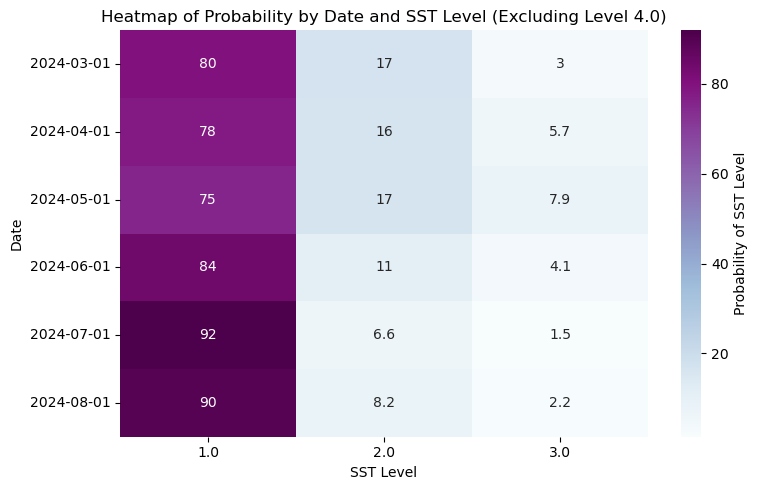

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


xtest['time'] = pd.to_datetime(xtest['time']).dt.date

# Filter out level 4.0
df_filtered = xtest[xtest['level'] != 4.0]

# 3. Heatmap of Probability by Date and Level
def heatmap_probability(df):
    pivot_table = df.pivot_table(index='time', columns='level', values='sst')
    print(pivot_table)
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_table, annot=True, cmap='BuPu', cbar_kws={'label': 'Probability of SST Level'})
    plt.title('Heatmap of Probability by Date and SST Level (Excluding Level 4.0)')
    plt.xlabel('SST Level')
    plt.ylabel('Date')
    plt.tight_layout()
    plt.show()

# Call the heatmap function
heatmap_probability(df_filtered)

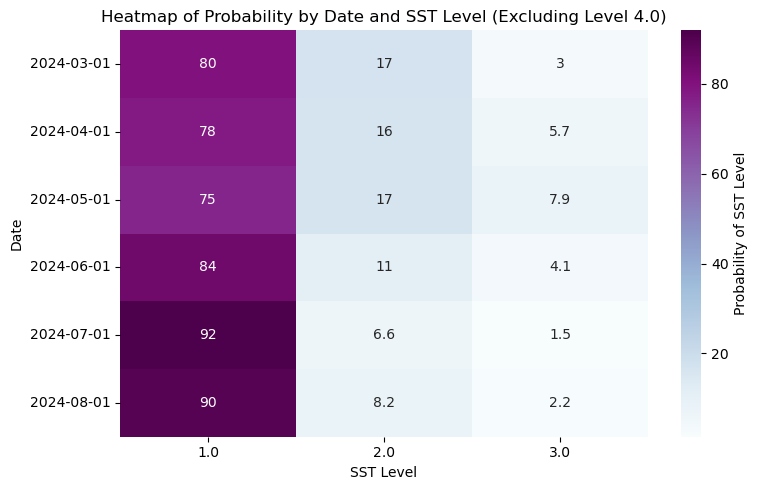

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


xtest['time'] = pd.to_datetime(xtest['time']).dt.date

# Filter out level 4.0
df_filtered = xtest[xtest['level'] != 4.0]

# 3. Heatmap of Probability by Date and Level
def heatmap_probability(df):
    pivot_table = df.pivot_table(index='time', columns='level', values='sst')
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_table, annot=True, cmap='BuPu', cbar_kws={'label': 'Probability of SST Level'})
    plt.title('Heatmap of Probability by Date and SST Level (Excluding Level 4.0)')
    plt.xlabel('SST Level')
    plt.ylabel('Date')
    plt.tight_layout()
    plt.show()

# Call the heatmap function
heatmap_probability(df_filtered)


In [66]:
import plotly.express as px
df = xtest[xtest['point'] == Point(130.5,1.5)]
df = df[df['level'] != 4.0]
line_fig = px.line(df, 
                   x='time', 
                   y='sst', 
                   color='level', 
                   title='SST Forecast Levels',
                   labels={'sst': 'Probability (%)', 'time': 'Date', 'level': 'Levels'},
                   markers=True)

# Show the line plot
line_fig.show()

# Create Stacked Bar Chart using Plotly Express
bar_fig = px.bar(df, 
                 x='time', 
                 y='sst', 
                 color='level', 
                 title='SST Probability Distribution',
                 labels={'sst': 'Probability (%)', 'time': 'Date', 'level': 'Levels'},
                 barmode='stack')

# Show the stacked bar chart
bar_fig.show()


In [67]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

df = xtest[xtest['point'] == Point(130.5,1.5)]
df = df[df['level'] != 4.0]

# Convert 'time' to datetime
df['time'] = pd.to_datetime(df['time'])

# Filter out level 4.0 if it exists
df_filtered = df[df['level'] != 4.0]

# Create a figure for the overlay plot
overlay_fig = go.Figure()

# Add stacked bars for each level using SST as probabilities
for level in df_filtered['level'].unique():
    level_data = df_filtered[df_filtered['level'] == level]
    overlay_fig.add_trace(go.Bar(
        x=level_data['time'], 
        y=level_data['sst'], 
        name=f'Level {int(level)}', 
        hoverinfo='y+name', 
        opacity=0.6
    ))

# Add lines for each level using SST as probabilities
for level in df_filtered['level'].unique():
    level_data = df_filtered[df_filtered['level'] == level]
    overlay_fig.add_trace(go.Scatter(
        x=level_data['time'], 
        y=level_data['sst'], 
        mode='lines+markers', 
        name=f'Level {int(level)} (Line)',
        line=dict(width=2),
        marker=dict(size=8)
    ))

# Update layout for overlay plot
overlay_fig.update_layout(
    title='Overlay of SST Probability Levels',
    xaxis_title='Date',
    yaxis_title='Probability (%)',
    barmode='stack',
    legend_title='Levels',
    template='plotly_white'
)

# Show the overlay plot
overlay_fig.show()


In [85]:
import pandas as pd
import plotly.graph_objects as go

# Assuming xtest is your data, filtering for specific 'point' and removing level 4.0
df = xtest[xtest['point'] == Point(130.5, 1.5)]
df = df[df['level'] != 4.0]

# Convert 'time' to datetime
df['time'] = pd.to_datetime(df['time'])

# Filter out level 4.0
df_filtered = df[df['level'] != 4.0]

# Define a color map for each level
color_map = {
    1.0: 'red',
    2.0: 'grey',
    3.0: 'blue'
}

# Create a figure for the overlay plot
overlay_fig = go.Figure()

# Add stacked bars for each level using SST as probabilities
for level in df_filtered['level'].unique():
    level_data = df_filtered[df_filtered['level'] == level]
    overlay_fig.add_trace(go.Bar(
        x=level_data['time'], 
        y=level_data['sst'], 
        name=f'Level {int(level)}', 
        hoverinfo='y+name', 
        opacity=0.6,
        marker_color=color_map[level],  # Set color for bar
        legendgroup=f'Level {int(level)}'
    ))

# Add lines for each level using SST as probabilities
for level in df_filtered['level'].unique():
    level_data = df_filtered[df_filtered['level'] == level]
    overlay_fig.add_trace(go.Scatter(
        x=level_data['time'], 
        y=level_data['sst'], 
        mode='lines+markers', 
        name=f'Level {int(level)} (Line)',
        line=dict(width=2, color=color_map[level]),  # Set color for line
        marker=dict(size=8, color=color_map[level]),  # Set color for markers
        legendgroup=f'Level {int(level)}'
    ))

# Update layout for overlay plot
overlay_fig.update_layout(
    title='Overlay of SST Probability Levels',
    xaxis_title='Date',
    yaxis_title='Probability (%)',
    barmode='stack',
    legend_title='Levels',
    template='plotly_white'
)

# Show the overlay plot
overlay_fig.show()


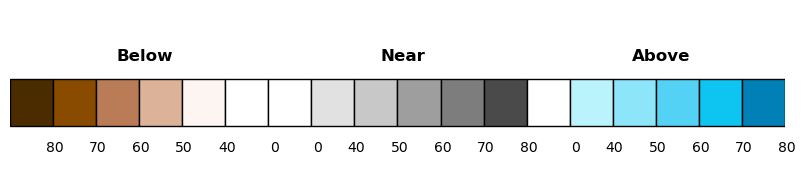

In [83]:
import matplotlib.pyplot as plt

# Define the data
categories = ['Below', 'Near', 'Above']
color_values = {
    'Below': ['#4A2C00', '#884B00', '#B97C56', '#DCB299', '#FDF5F2', '#FFFFFF'],  # 80 to 0
    'Near': ['#FFFFFF', '#E1E1E1', '#C8C8C8', '#9E9E9E', '#7D7D7D', '#4A4A4A'],   # 0 to 80
    'Above': ['#FFFFFF', '#BBF3FC', '#8DE5FA', '#54D2F5', '#0EC5F1', '#0080B6']   # 0 to 80
}
values = {
    'Below': [80, 70, 60, 50, 40, 0],
    'Near': [0, 40, 50, 60, 70, 80],
    'Above': [0, 40, 50, 60, 70, 80]
}

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 2))

block_width = 0.8  # width of each color block
block_height = 0.6  # height of each color block

# Loop through each category and plot the colors without spaces
x_index = 0  # Starting x position
for category in categories:
    # Add category label above the blocks
    plt.text(x_index + 2.5, 0.8, category, ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Plot each color block and the corresponding number
    for j, color in enumerate(color_values[category]):
        rect = plt.Rectangle((x_index, 0), block_width, block_height, color=color, ec='black')
        ax.add_patch(rect)
        # Add number to the right of the block
        plt.text(x_index + block_width + 0.2, -0.2, str(values[category][j]), ha='right', va='top', fontsize=10)
        x_index += block_width  # Move to the next position directly

# Remove axes and display
ax.set_axis_off()
plt.xlim(0, x_index)  # Adjust x limits
plt.ylim(-0.5, 1.5)   # Adjust y limits for labels and blocks

plt.show()
